In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("CVD EDA") \
    .getOrCreate()

# Path đến dữ liệu
current_dir = os.getcwd()
project_dir = os.path.dirname(current_dir)
data_path = os.path.join(project_dir, "data_raw", "CVD_cleaned.csv")

# Đọc dữ liệu
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.show(5)

+--------------+--------------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|General_Health|             Checkup|Exercise|Heart_Disease|Skin_Cancer|Other_Cancer|Depression|Diabetes|Arthritis|   Sex|Age_Category|Height_(cm)|Weight_(kg)|  BMI|Smoking_History|Alcohol_Consumption|Fruit_Consumption|Green_Vegetables_Consumption|FriedPotato_Consumption|
+--------------+--------------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|          Poor|Within the past 2...|      No|           No|         No|          No|        No|      No|      Yes|Female|       70-74|      150.0|      32.66|14.54|            Yes|

In [2]:
# Hiển thị schema
df.printSchema()

root
 |-- General_Health: string (nullable = true)
 |-- Checkup: string (nullable = true)
 |-- Exercise: string (nullable = true)
 |-- Heart_Disease: string (nullable = true)
 |-- Skin_Cancer: string (nullable = true)
 |-- Other_Cancer: string (nullable = true)
 |-- Depression: string (nullable = true)
 |-- Diabetes: string (nullable = true)
 |-- Arthritis: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age_Category: string (nullable = true)
 |-- Height_(cm): double (nullable = true)
 |-- Weight_(kg): double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking_History: string (nullable = true)
 |-- Alcohol_Consumption: double (nullable = true)
 |-- Fruit_Consumption: double (nullable = true)
 |-- Green_Vegetables_Consumption: double (nullable = true)
 |-- FriedPotato_Consumption: double (nullable = true)



In [3]:
# Phân tích dữ liệu với Spark SQL
df.createOrReplaceTempView("cvd")

# Tổng quan dữ liệu
overview = spark.sql("""
    SELECT 
        COUNT(*) as total, 
        AVG(BMI) as avg_bmi, 
        MIN(BMI) as min_bmi, 
        MAX(BMI) as max_bmi 
    FROM cvd
""")
overview.show()

+------+-----------------+-------+-------+
| total|          avg_bmi|min_bmi|max_bmi|
+------+-----------------+-------+-------+
|308854|28.62621053960776|  12.02|  99.33|
+------+-----------------+-------+-------+



+-------------+------+
|Heart_Disease| count|
+-------------+------+
|           No|283883|
|          Yes| 24971|
+-------------+------+



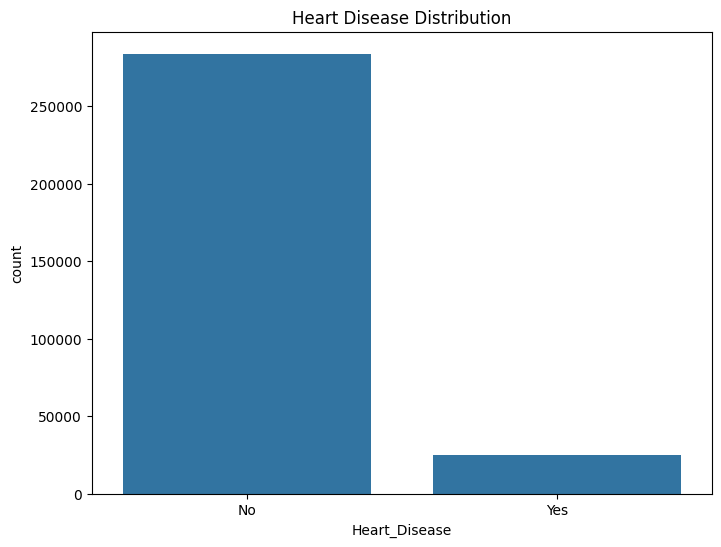

In [4]:
# Phân bố Heart Disease
heart_disease_dist = spark.sql("""
    SELECT Heart_Disease, COUNT(*) as count 
    FROM cvd 
    GROUP BY Heart_Disease
""")
heart_disease_dist.show()

# Convert to pandas for visualization
heart_disease_pd = heart_disease_dist.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x='Heart_Disease', y='count', data=heart_disease_pd)
plt.title('Heart Disease Distribution')
plt.show()

+-------------+------------------+
|Heart_Disease|           avg_bmi|
+-------------+------------------+
|           No|28.543676021459436|
|          Yes|29.564504825597695|
+-------------+------------------+



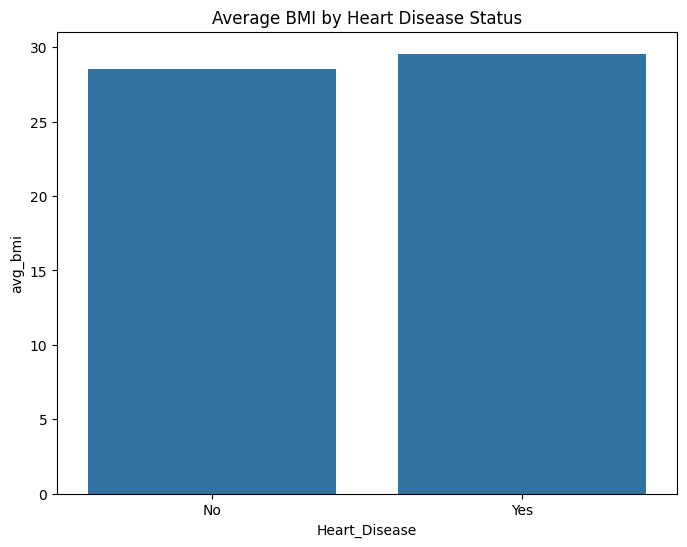

In [5]:
# BMI theo Heart Disease
bmi_by_heart_disease = spark.sql("""
    SELECT Heart_Disease, AVG(BMI) as avg_bmi 
    FROM cvd 
    GROUP BY Heart_Disease
""")
bmi_by_heart_disease.show()

# Convert to pandas for visualization
bmi_pd = bmi_by_heart_disease.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x='Heart_Disease', y='avg_bmi', data=bmi_pd)
plt.title('Average BMI by Heart Disease Status')
plt.show()

+------------+-------------+-----+
|Age_Category|Heart_Disease|count|
+------------+-------------+-----+
|       18-24|           No|18587|
|       18-24|          Yes|   94|
|       25-29|           No|15381|
|       25-29|          Yes|  113|
|       30-34|          Yes|  201|
|       30-34|           No|18227|
|       35-39|          Yes|  274|
|       35-39|           No|20332|
|       40-44|           No|21160|
|       40-44|          Yes|  435|
|       45-49|           No|20290|
|       45-49|          Yes|  678|
|       50-54|           No|23916|
|       50-54|          Yes| 1181|
|       55-59|          Yes| 1991|
|       55-59|           No|26063|
|       60-64|           No|29406|
|       60-64|          Yes| 3012|
|       65-69|          Yes| 3823|
|       65-69|           No|29611|
+------------+-------------+-----+
only showing top 20 rows



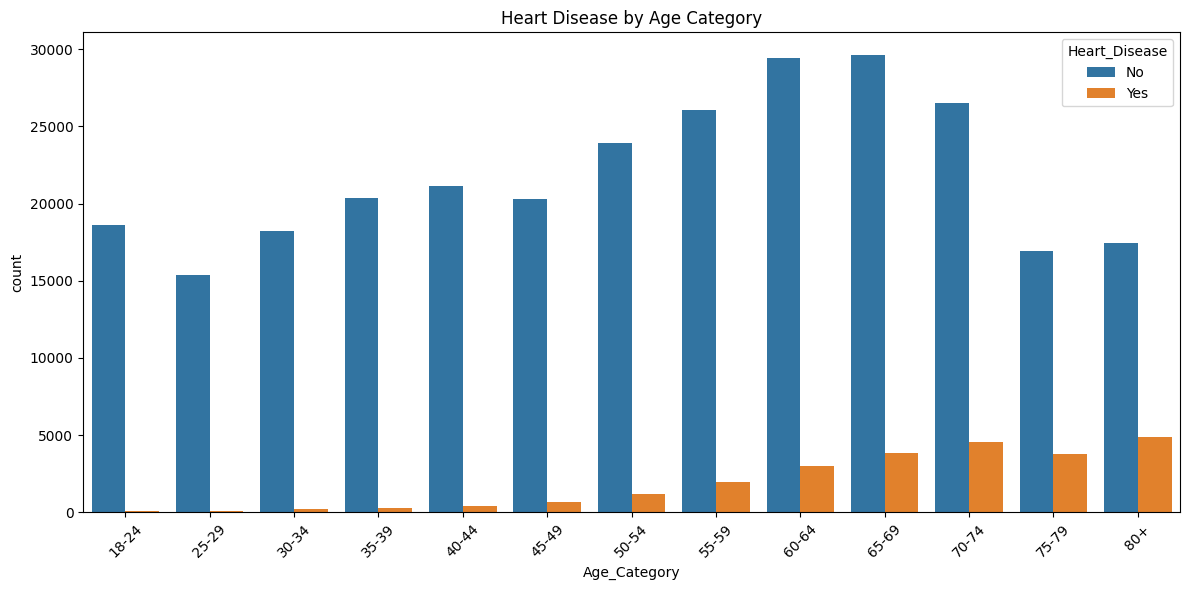

In [6]:
# Phân bố Heart Disease theo Age Category
age_heart = spark.sql("""
    SELECT Age_Category, Heart_Disease, COUNT(*) as count 
    FROM cvd 
    GROUP BY Age_Category, Heart_Disease 
    ORDER BY Age_Category
""")
age_heart.show()

# Convert to pandas for visualization
age_heart_pd = age_heart.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='Age_Category', y='count', hue='Heart_Disease', data=age_heart_pd)
plt.title('Heart Disease by Age Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

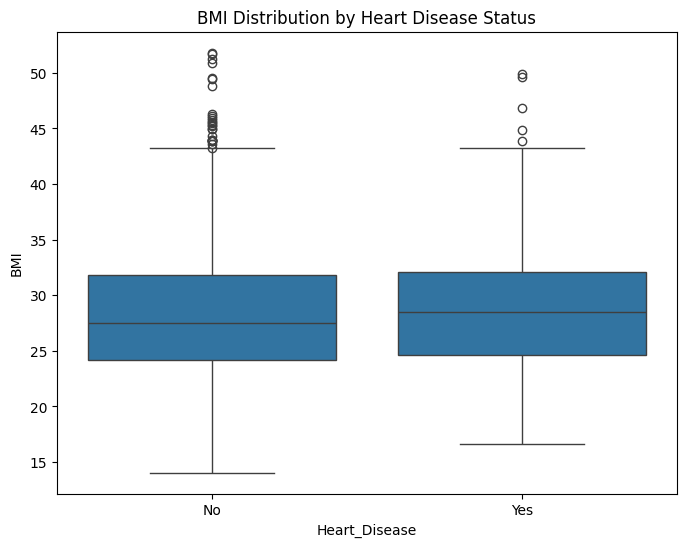

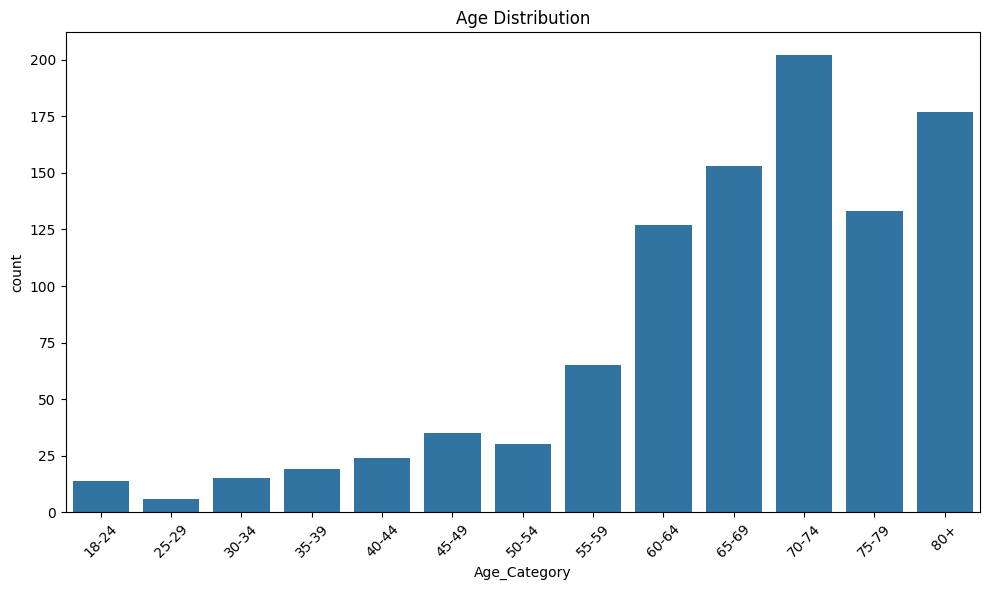

In [7]:
# Xem thêm dữ liệu với pandas
sample_pd = df.limit(1000).toPandas()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Heart_Disease', y='BMI', data=sample_pd)
plt.title('BMI Distribution by Heart Disease Status')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Age_Category', data=sample_pd, order=sorted(sample_pd['Age_Category'].unique()))
plt.title('Age Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

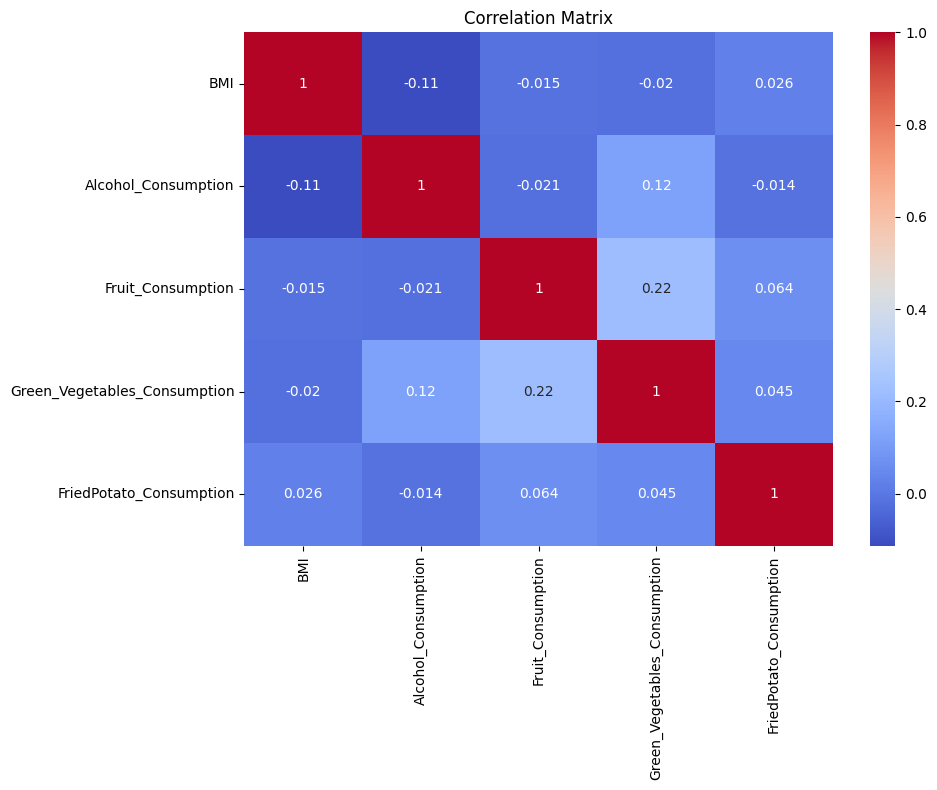

In [8]:
# Correlation giữa các biến số
numeric_cols = ['BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 
                'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
numeric_data = sample_pd[numeric_cols]

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()